## Overview of the  rest of the term
- final project submission deeadline: December 3, 11:59pm
- final project presentations: December 4, 5, 6, 4pm to 6:30pm in 275 (one floor below DSI)
- thursday's lecture is review
   - bring questions or ask me on piazza
- final exam: December 10
   - closed book written exam, lasts an hour
- grades by December 17-18
- final grades submitted by December 20

## Deployment and continuous monitoring
By the end of this lecture, you will be able to
- Describe A/B testing and when it's not the right approach to test
- Describe common challenges with deployment
- Develop strategies to monitor a deployed ML model


- you put together the ML pipeline (splitting, preprocessing, parameter tuning)
- tried a couple of supervised ML algorithms
- you have a test score with uncertainty
- feature importance metrics
- you understand and trust your model
## ... now what?


## It is time to deploy the model!
- up to now you played in a sandbox
   - you worked with historical data
   - no actual decisions were made based on the work you did so far
- once your model is deployed, it will replace whatever decision making process was in place until now
   - this is done carefully and gradually

## Typical scenario
- you get more recent data and you need to apply your model to it (pre-deployment)
- A/B testing (your model is partially deployed)
   - evidence-based comparison of the ML approach and the previous decision making process
- if your model is better than the previous decision making process, your model will replace it (full deployment)

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Describe A/B testing and when it's not the right approach to test**
- <font color='LIGHTGRAY'>Describe common challenges with deployment</font>
- <font color='LIGHTGRAY'>Develop strategies to monitor a deployed ML model</font>


## A/B testing - example
**My project with Advancement**
- goal: predict how much alumni will donate in the upcoming fiscal year
   - the predictions are used as target ask amounts in phone/mail/email communication
- previous decision making process:
   - a group of experts meet regularly for a couple of weeks to discuss the what a good target ask amount is
   - very labor-intensive and also somewhat subjective
- a regression model was developed by my colleague and myself with R2 scores in the range of 0.7-0.8
- it was time to test it

## A/B testing - example
- Advancement created two groups:
   - group A (control) - the previous decision making process was used to generate target ask amounts
   - group B (treatment) - the regression model's prediction were used
- alumni were randomly assigned to the two groups
   - we checked that key demographic groups (race/gender/ethnicity) were more or less evenly distributed in the two groups
- the only difference between the two groups were the decision making process used, everything else was the same.
- we waited a year :D

## A/B testing - example
- we compared the donations given by the two groups using statistical tests
   - we used a two sided t test to compare the donation distributions in groups A and B
- unfortunately we found that my model does not increase the amount the alumni donate 
- the model was still adopted by Advancement because it saves a ton of work for them
   - several people's work time freed up so they can do better, more important things now
- this year, my model completely replaced Advancement's previous decision making process

## A/B testing - general concept
- create two groups usually semi-randomly
   - if you have segments (groups of interest), make sure that the segments are more or less evenly represented in both groups
- the two groups are similar in all but one aspect
   - group A (control): the previous decision making process is applied on them
   - group B (treatment): your new ML model is applied on them
- wait for the results to come in
- use a statistical test to compare the target variable of the two groups (see [here](https://en.wikipedia.org/wiki/A/B_testing#Common_test_statistics))

## A/B testing - estimate sample size
- How many people should be in the two groups?
   - Do we have segments?
   - What difference in performance would you expect between the previous and the new decision making process?
   - What is the distribution/type of the target variable? (determines the test you should use)
   - What significance level (p value) would you like to achieve?

## A/B testing - estimate sample size
An example:
- we have segments
- we have a classification model and the difference in accuracy is 5% between the previous and new processes
   - previous process has an 80% accuracy
   - new process has an 85% expected accuracy based on the mean test score
- target variable is binary, we want to compare odds ratios (Fischer's exact test)
- we are interested in a 0.01 or lower p value
- **let's simulate this to estimate the sample size**

In [1]:
import numpy as np
import scipy.stats as stats
np.random.seed(0)
n_samples = [500,1000,1500,2000] # sample size in a segment
A_acc = 0.8 # accuracy in the control group
B_acc = 0.85 # expected accuracy in the treatment group

# let's loop through n, simulate data, apply t test to simulated data
median_p = np.zeros(len(n_samples))
upper_p = np.zeros(len(n_samples))
lower_p = np.zeros(len(n_samples))
for n in range(len(n_samples)):
    p_vals = []
    for i in range(100):
        A_results = np.random.choice([0, 1], size=(n_samples[n]), p=[1-A_acc, A_acc])
        B_results = np.random.choice([0, 1], size=(n_samples[n]), p=[1-B_acc, B_acc])
        oddsratio, pvalue = stats.fisher_exact([[sum(A_results==0), sum(A_results==1)], [sum(B_results==0), sum(B_results==1)]])
        p_vals.append(pvalue)
        
    median_p[n] = np.median(p_vals)
    upper_p[n] = np.percentile(p_vals,84) # you can also do np.max(p_vals)
    lower_p[n] = np.percentile(p_vals,16) # you can also do np.min(p_vals)


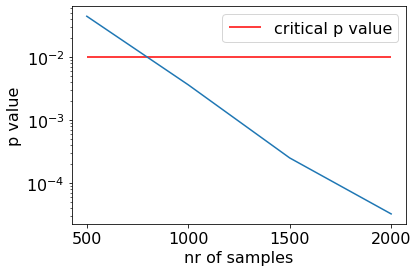

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.errorbar(n_samples,median_p,yerr=np.array([median_p-lower_p,upper_p-median_p]),capsize=5,fmt='o')
plt.hlines(0.01,n_samples[0],n_samples[-1],color='r',label='critical p value')
plt.xlabel('nr of samples')
plt.ylabel('p value')
plt.semilogy()
plt.legend()
plt.show()

## A/B testing - when it is not the right approach
- testing is not ethical
   - [facebook scandal](https://techcrunch.com/2014/06/29/ethics-in-a-data-driven-world/)
   - you need approval from Ethics Board or IRB
- testing is approved but you want to minimize variations in user experience 
   - you shouldn't ask different users to pay different amounts for the same service
   - they will start to complain :)
   - multi-armed bandit is a good alternative to minimize costs like this (read about it [here](https://en.wikipedia.org/wiki/Multi-armed_bandit) and [here](https://towardsdatascience.com/when-and-when-not-to-a-b-test-c901f3ad96d9))

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe A/B testing and when it's not the right approach to test</font>
- **Describe common challenges with deployment**
- <font color='LIGHTGRAY'>Develop strategies to monitor a deployed ML model</font>


## Once the model is tested and deployed, you are not done
- incoming data properties can change
   - feature distributions could slowly move away from what you had in training
   - category ratios could change
   - new classes could appear
   - outliers in regression could become the new norm

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Describe A/B testing and when it's not the right approach to test</font>
- <font color='LIGHTGRAY'>Describe common challenges with deployment</font>
- **Develop strategies to monitor a deployed ML model**

## What to do?
- incoming data needs to be monitored
- keep an eye on feature statistics and the target variable properties
- if you see the data changing, retrain your model


By now you know
- Describe A/B testing and when it's not the right approach to test
- Describe common challenges with deployment
- Develop strategies to monitor a deployed ML model
